In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest



sns.set_style('whitegrid')

import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(10,5)})

if not "root" in locals():
    current_path = Path(os.getcwd())
    root = current_path.parent.absolute()
os.chdir(root)

from tools.add_AR_cols import add_AR_cols
from data_treatment.box_creator import create_binary_box
PATH = "../"

In [2]:
df = pd.read_csv('database.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = create_binary_box(df, relative_threshold = 0.05, box_length=5).set_index(['Date']).dropna(axis = 0)
df[['PX_OPEN_VIX_volatility','Box']]
df = add_AR_cols(df,7)

In [3]:
y = df['Box']
X = df.drop(['Box', 'Neutral_SENTIMENT', 'Bull-Bear Spread_SENTIMENT'], axis=1)
X = (X - X.mean())/X.std()

In [4]:
selec_model = SelectKBest(k=40)
selec_model.fit(X, y)
selected_cols = selec_model.get_feature_names_out()

X= X[selected_cols]

In [5]:
coeffs_list =[]
l_s = np.linspace(0.2,0,200)

lasso = LogisticRegression(C=l_s[0], fit_intercept=True, penalty='l1', solver='saga')
lasso.fit(X,y)
coeffs_list.append(lasso.coef_[0])

X =X [np.array(X.columns)[coeffs_list[0]!=0]]


tab_coeff = np.empty([len(l_s)-1,len(X.columns)])

l_s = l_s[1:]

for i in range(len(l_s)):
    lasso = LogisticRegression(C=l_s[i], fit_intercept=True, penalty='l1', solver='saga')
    lasso.fit(X,y)
    tab_coeff[i,:]= lasso.coef_[0]

/Users/thomaskientz/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/thomaskientz/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/thomaskientz/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/thomaskientz/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/thomaskientz/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/thomaskientz/miniforge3

In [6]:
coeff_df = pd.DataFrame(data=tab_coeff[::-1], index=l_s[::-1], columns=X.columns)
coeff_df["Valid cols"] = coeff_df[coeff_df!=0].count(axis=1)

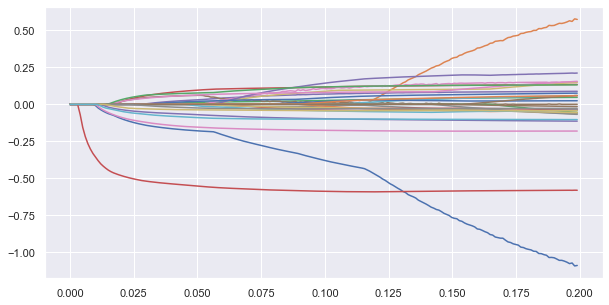

In [8]:
plot = coeff_df.drop("Valid cols", axis=1).plot(legend= False)
plt.show()

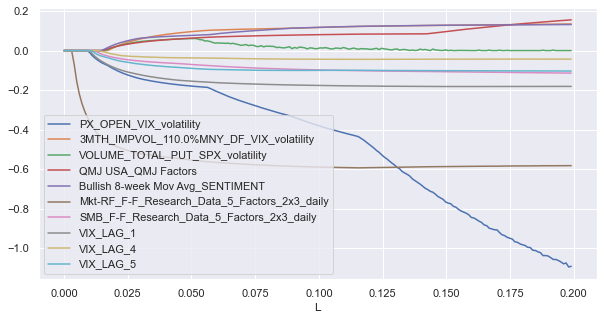

In [13]:
first_cols = coeff_df[coeff_df['Valid cols']==10][coeff_df!=0].dropna(axis=1).columns

plot = coeff_df[first_cols].drop("Valid cols", axis=1).plot()
plt.show()

In [11]:
plot = coeff_df[first_cols].drop("Valid cols", axis=1)
plot.index.name = "L"

In [12]:
#!pip install plotly
import plotly.express as px
fig = px.line(plot, x=plot.index, y=plot.columns)
with open("analysis/lasso_selection_graph.html", "w") as f:
    f.write(fig.to_html())